<a href="https://colab.research.google.com/github/chiaolun/vis-2025-spring/blob/main/2025.02.20%20-%20Elastic%20Collisions%20-%20Newtonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elastic Collision between two particles

In [ ]:
import sympy as sp
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
# -------------------------------
# 1) Define symbolic expressions using Sympy
# -------------------------------

# Define symbolic variables for the positions
x1, x2 = sp.symbols('x1 x2', real=True)

# Define the repulsive potential energy: V = 1/|x2 - x1|
V = 1/sp.Abs(x2 - x1)

# Compute forces using Newton's second law: F = -dV/dx
F1 = -sp.diff(V, x1)
F2 = -sp.diff(V, x2)

# Simplify expressions (they will be computed piecewise internally)
F1 = sp.simplify(F1)
F2 = sp.simplify(F2)

display("F1:", F1)  # Expected to yield: F1 = -sign(x2 - x1) / |x2 - x1|^2
display("F2:", F2)  # Expected to yield: F2 = sign(x2 - x1) / |x2 - x1|^2

# Lambdify the force expressions for numerical evaluation
f1_func = sp.lambdify((x1, x2), F1, modules="numpy")
f2_func = sp.lambdify((x1, x2), F2, modules="numpy")

'F1:'

Piecewise((0, Eq(x1, x2)), (1/((x1 - x2)*Abs(x1 - x2)), True))

'F2:'

Piecewise((0, Eq(x1, x2)), (-1/((x1 - x2)*Abs(x1 - x2)), True))

In [ ]:
# -------------------------------
# 2) Define the ODE system using Newton's F = m*a
# -------------------------------

# Define masses
m1 = 1.0
m2 = 1.0

def system_newtonian(t, y):
    """
    Compute the time-derivative of the state vector using Newtonian mechanics.

    The state vector is:
       y = [x1, x2, v1, v2]
    where
       dx1/dt = v1,
       dx2/dt = v2,
       dv1/dt = F1/m1,
       dv2/dt = F2/m2.
    The forces F1 and F2 are computed using the sympy-derived functions.
    """
    x1, x2, v1, v2 = y
    F1 = f1_func(x1, x2)
    F2 = f2_func(x1, x2)
    a1 = F1 / m1
    a2 = F2 / m2
    return [v1, v2, a1, a2]

In [ ]:
# -------------------------------
# 3) Set up and solve the ODE system
# -------------------------------

# Initial conditions for positions and velocities
x1_0 = -125.0   # initial position of mass 1
x2_0 = -2.65 # initial position of mass 2
v1_0 = 1.0      # initial velocity of mass 1
v2_0 = 0.0      # initial velocity of mass 2
y0 = [x1_0, x2_0, v1_0, v2_0]

# Define simulation time span
t_max = 250
t_eval = np.linspace(0, t_max, 1000)

# Solve the system using SciPy's solve_ivp
sol = solve_ivp(system_newtonian, [0, t_max], y0, t_eval=t_eval, rtol=1e-9, atol=1e-9)
solution = pd.DataFrame(sol.y.T, columns=['x1', 'x2', 'v1', 'v2'], index=sol.t)
solution

,x1,x2,v1,v2
0.000000,-125.000000,-2.650000,1.000000,0.000000
0.250250,-124.749752,-2.649998,0.999983,0.000017
0.500501,-124.499508,-2.649992,0.999966,0.000034
0.750751,-124.249268,-2.649981,0.999950,0.000050
1.001001,-123.999033,-2.649966,0.999933,0.000067
...,...,...,...,...
248.998999,2.666894,118.682105,0.000446,0.999554
249.249249,2.667003,118.932246,0.000428,0.999572
249.499499,2.667108,119.182391,0.000409,0.999591
249.749750,2.667208,119.432541,0.000391,0.999609


<Axes: title={'center': 'Potential Energy vs Separation r'}, xlabel='r', ylabel='Potential Energy V'>

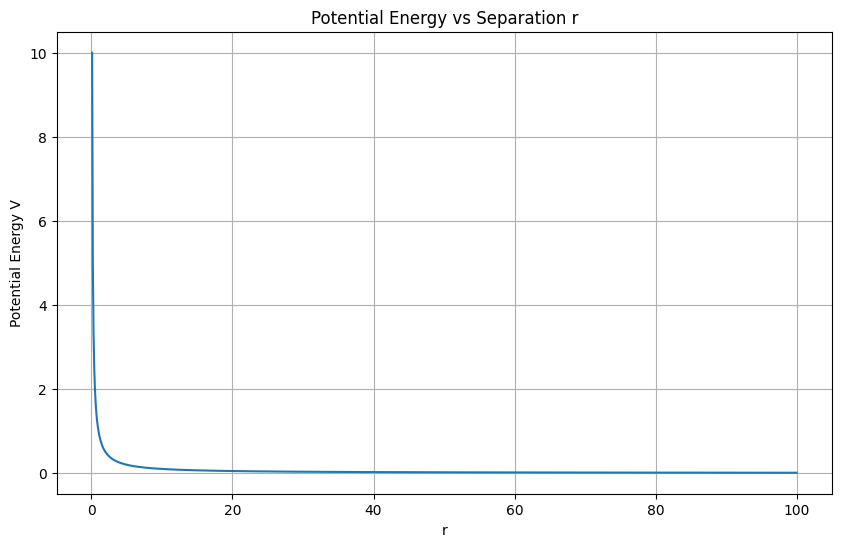

In [ ]:
# -------------------------------
# 4) Plot the results
# -------------------------------

# Plot the potential energy vs separation
r_eval = np.linspace(0.1, 100, 1000)
V_func = sp.lambdify((x1, x2), V)  # lambdify the potential function
V_eval = V_func(r_eval, 0)  # as the potential V = 1/|r| with r = separation
pd.Series(data=V_eval, index=r_eval).plot(
    figsize=(10, 6),
    xlabel='r',
    ylabel='Potential Energy V',
    title='Potential Energy vs Separation r',
    grid=True
)

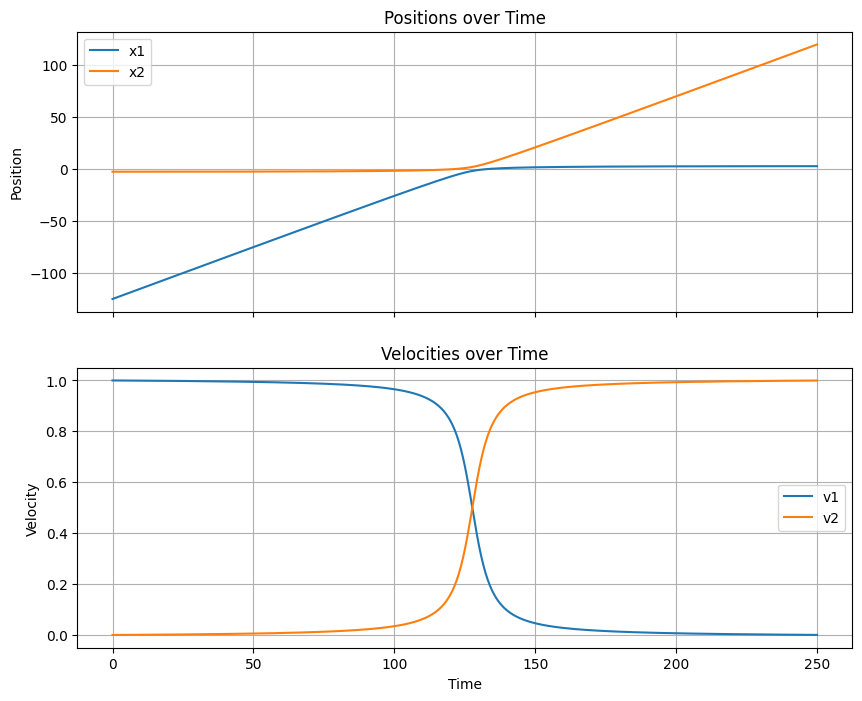

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Plot positions over time
solution[["x1", "x2"]].plot(xlabel='Time', ylabel='Position',
                           title='Positions over Time', grid=True, ax=ax1)

# Plot velocities over time
solution[["v1", "v2"]].plot(xlabel='Time', ylabel='Velocity',
                           title='Velocities over Time', grid=True, ax=ax2);

In [ ]:
thinned_solution = solution.iloc[::10]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, height_ratios=[1, 5])

# Set axis limits for particle animation subplot
x_min = min(thinned_solution[['x1', 'x2']].min()) - 0.5
x_max = max(thinned_solution[['x1', 'x2']].max()) + 0.5
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(-1, 1)
ax1.set_title('Particle Collision')

# Create particle objects
particle1, = ax1.plot([], [], 'bo', markersize=5, label='Particle 1')
particle2, = ax1.plot([], [], 'ro', markersize=5, label='Particle 2')

# Set up position over time subplot
ax2.set_ylim(thinned_solution.index.max(), 0)  # Reversed y-axis limits to make time flow top to bottom
ax2.set_xlim(x_min, x_max)
ax2.set_title('Position vs Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Position')

# Plot full position data with flipped axes
ax2.plot(thinned_solution['x1'], thinned_solution.index, 'b-', label='Particle 1')
ax2.plot(thinned_solution['x2'], thinned_solution.index, 'r-', label='Particle 2')
ax2.legend()

# Create time indicator line
time_line, = ax2.plot([], [], 'g-', linewidth=1)

# Animation initialization function
def init():
    particle1.set_data([], [])
    particle2.set_data([], [])
    time_line.set_data([], [])
    return particle1, particle2, time_line

# Animation update function
def animate(frame):
    # Update particles
    particle1.set_data([thinned_solution.iloc[frame]['x1']], [0])
    particle2.set_data([thinned_solution.iloc[frame]['x2']], [0])

    # Update time indicator line - now horizontal instead of vertical
    time = thinned_solution.index[frame]
    time_line.set_data([x_min, x_max], [time, time])

    return particle1, particle2, time_line

# Create animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(thinned_solution),
    interval=50,  # 50ms between frames
    blit=True,
    repeat=False  # Prevent repeating after animation ends
)
plt.close(fig)

# Display animation
HTML(anim.to_html5_video())
